Saving train.csv to train.csv
User uploaded file "train.csv" with length 3103165 bytes


Saving test.csv to test.csv
User uploaded file "test.csv" with length 1635543 bytes


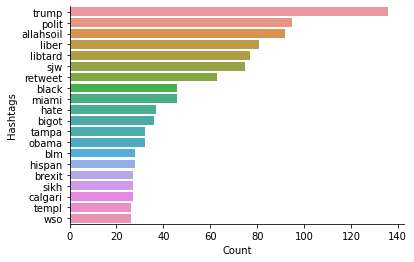

In [1]:
import re
import pandas as pd 
import numpy as np 
import io
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
from sklearn.linear_model import LogisticRegression

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
	  
uploaded


train = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))
train.head()

train_original=train.copy()
train.shape
train_original

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
	  
uploaded


test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))
test.tail()

test_original=test.copy()
test.shape
test_original

combine = train.append(test,ignore_index=True,sort=True)


def remove_pattern(text,pattern):
    
  
    r = re.findall(pattern,text)
    
  
    for i in r:
        text = re.sub(i,"",text)
    
    return text 

combine['Tidy_Tweets'] = np.vectorize(remove_pattern)(combine['tweet'], "@[\w]*")

combine.head()

combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.replace("[^a-zA-Z#]", " ")

combine.head()

combine['Tidy_Tweets'] = combine['Tidy_Tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

combine.head(10)

tokenized_tweet = combine['Tidy_Tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

from nltk import PorterStemmer

ps = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])

tokenized_tweet.head()

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combine['Tidy_Tweets'] = tokenized_tweet
combine.head()

all_words_negative = ' '.join(text for text in combine['Tidy_Tweets'][combine['label']==1])

def Hashtags_Extract(x):
    hashtags=[]
    
    
    for i in x:
        ht = re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    
    return hashtags

ht_negative = Hashtags_Extract(combine['Tidy_Tweets'][combine['label']==1])
ht_negative_unnest = sum(ht_negative,[])


word_freq_negative = nltk.FreqDist(ht_negative_unnest)
word_freq_negative
df_negative = pd.DataFrame({'Hashtags':list(word_freq_negative.keys()),'Count':list(word_freq_negative.values())})
df_negative.head(10)

df_negative_plot = df_negative.nlargest(20,columns='Count')
sns.barplot(data=df_negative_plot,y='Hashtags',x='Count')
sns.despine()
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

bow = bow_vectorizer.fit_transform(combine['Tidy_Tweets'])

df_bow = pd.DataFrame(bow.todense())

df_bow

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')

tfidf_matrix=tfidf.fit_transform(combine['Tidy_Tweets'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())

df_tfidf

train_tfidf_matrix = tfidf_matrix[:31962]

train_tfidf_matrix.todense()
train_bow = bow[:31962]

train_bow.todense()

from sklearn.model_selection import train_test_split

x_train_bow,x_valid_bow,y_train_bow,y_valid_bow = train_test_split(train_bow,train['label'],test_size=0.3,random_state=2)

x_train_tfidf,x_valid_tfidf,y_train_tfidf,y_valid_tfidf = train_test_split(train_tfidf_matrix,train['label'],test_size=0.3,random_state=17)

from sklearn.linear_model import LogisticRegression
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs')

Log_Reg.fit(x_train_bow,y_train_bow)
prediction_bow = Log_Reg.predict_proba(x_valid_bow)

prediction_bow


from sklearn.metrics import f1_score

prediction_int = prediction_bow[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)
prediction_int


log_bow = f1_score(y_valid_bow, prediction_int)

Log_Reg.fit(x_train_tfidf,y_train_tfidf)

prediction_tfidf = Log_Reg.predict_proba(x_valid_tfidf)

prediction_tfidf

prediction_int = prediction_tfidf[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_tfidf = f1_score(y_valid_tfidf, prediction_int)

log_tfidf

test_tfidf = tfidf_matrix[31962:]


test_pred = Log_Reg.predict_proba(test_tfidf)

test_pred_int = test_pred[:,1] >= 0.3

test_pred_int = test_pred_int.astype(np.int)

test['label'] = test_pred_int

submission = test[['id','label']]

submission.to_csv('result.csv', index=False)

res = pd.read_csv('result.csv')


In [2]:
log_bow

0.5721352019785655

In [3]:
log_tfidf

0.5862068965517241

In [4]:
res

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0
...,...,...
17192,49155,1
17193,49156,0
17194,49157,0
17195,49158,0


In [6]:
df=train_original
print(df.iloc[25])

id                                                      26
label                                                    0
tweet    beautiful sign by vendor 80 for $45.00!! #upsi...
Name: 25, dtype: object
